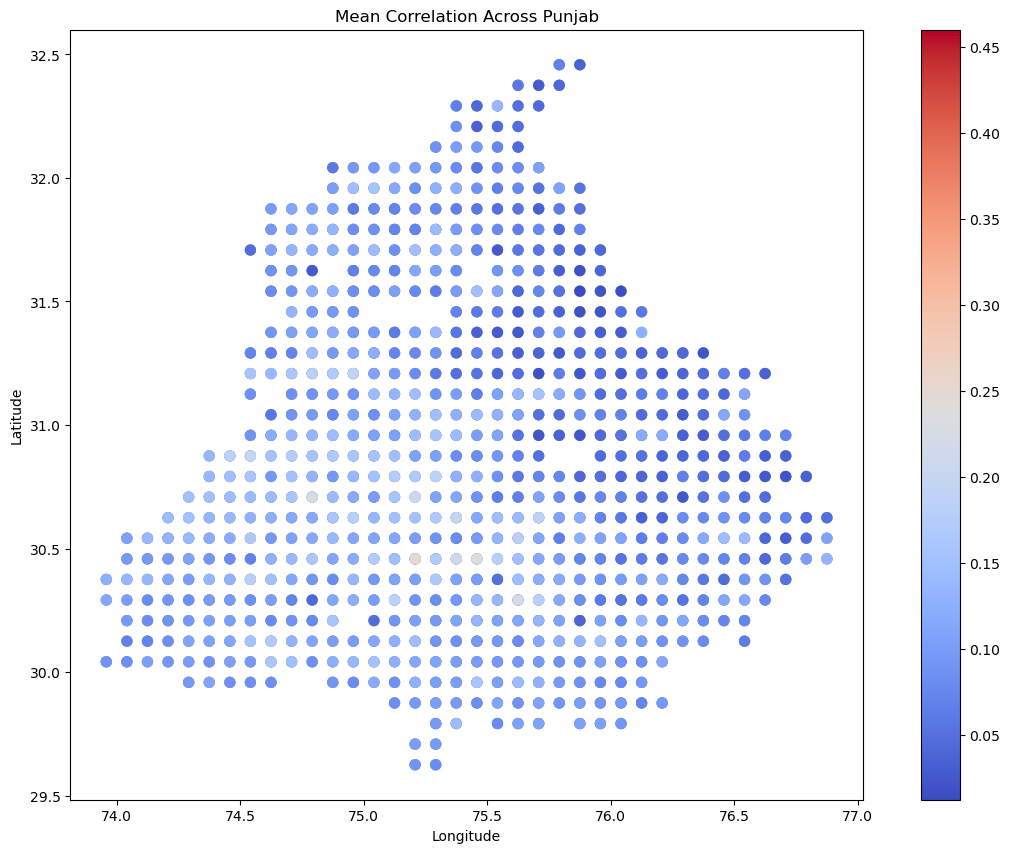

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load your data from Excel file
data = pd.read_excel(r"C:\Users\riya kansal\Desktop\2015.xlsx")  # Replace with your actual data file path and sheet name

# List of all unique latitude and longitude points
lat_lon_points = data[['LATITUDE', 'LONGITUDE']].drop_duplicates().values.tolist()

# List of fortnight columns for NDVI
ndvi_columns = [f'NDVI{i}' for i in range(1, 9)]

# Create a dictionary to hold correlation matrices for each point
correlation_dict = {}

# Calculate correlation matrices
for point in lat_lon_points:
    lat, lon = point
    subset = data[(data['LATITUDE'] == lat) & (data['LONGITUDE'] == lon)]
    
    for i in range(1, 9):
        param_cols = [
            f'MaxTemp{i}', f'MinTemp{i}',
            f'DaysMaxTempAbove16{i}', f'DaysMaxTempAbove18{i}', f'DaysMaxTempAbove20{i}', f'DaysMaxTempAbove24{i}',
            f'DaysMinTempBelow16{i}', f'DaysMinTempBelow18{i}', f'DaysMinTempBelow20{i}', f'DaysMinTempBelow24{i}',
            f'Percentile99_Max{i}', f'Percentile95_Max{i}', f'Percentile90_Max{i}',
            f'Percentile99_Min{i}', f'Percentile95_Min{i}', f'Percentile90_Min{i}'
        ]
        combined_cols = ndvi_columns + param_cols
        subset_combined = subset[combined_cols]
        
        corr_matrix = subset_combined.corr()
        correlation_dict[f'Location_{lat}_{lon}_Fortnight_{i}'] = corr_matrix

# Save correlation matrices to an Excel file
output_file = r"C:\Users\riya kansal\Desktop\2014.xlsx"
with pd.ExcelWriter(output_file) as writer:
    for index, (location, corr_matrix) in enumerate(correlation_dict.items()):
        sheet_name = f'Sheet{index+1:03d}'  # Generate unique sheet names like 'Sheet001', 'Sheet002', etc.
        corr_matrix.to_excel(writer, sheet_name=sheet_name)

# Create a GeoDataFrame with correlation values
corr_values = []
for point, matrix in correlation_dict.items():
    lat, lon = map(float, point.split('_')[1:3])
    max_corr = matrix.values.flatten().max()
    min_corr = matrix.values.flatten().min()
    mean_corr = matrix.values.flatten().mean()
    corr_values.append({'LATITUDE': lat, 'LONGITUDE': lon, 'max_corr': max_corr, 'min_corr': min_corr, 'mean_corr': mean_corr})

corr_df = pd.DataFrame(corr_values)
gdf = gpd.GeoDataFrame(corr_df, geometry=gpd.points_from_xy(corr_df.LONGITUDE, corr_df.LATITUDE))

# Define the output directory for saving the image
output_image_directory =  r"C:\Users\riya kansal\Desktop\shap_plots"   # Define your output directory
os.makedirs(output_image_directory, exist_ok=True)  # Create the directory if it doesn't exist
output_image_path = os.path.join(output_image_directory, 'mean_correlation_map.png')

# Plot the correlations on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(ax=ax, column='mean_corr', cmap='coolwarm', legend=True, markersize=50)
plt.title('Mean Correlation Across Punjab')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig(output_image_path)

plt.show()


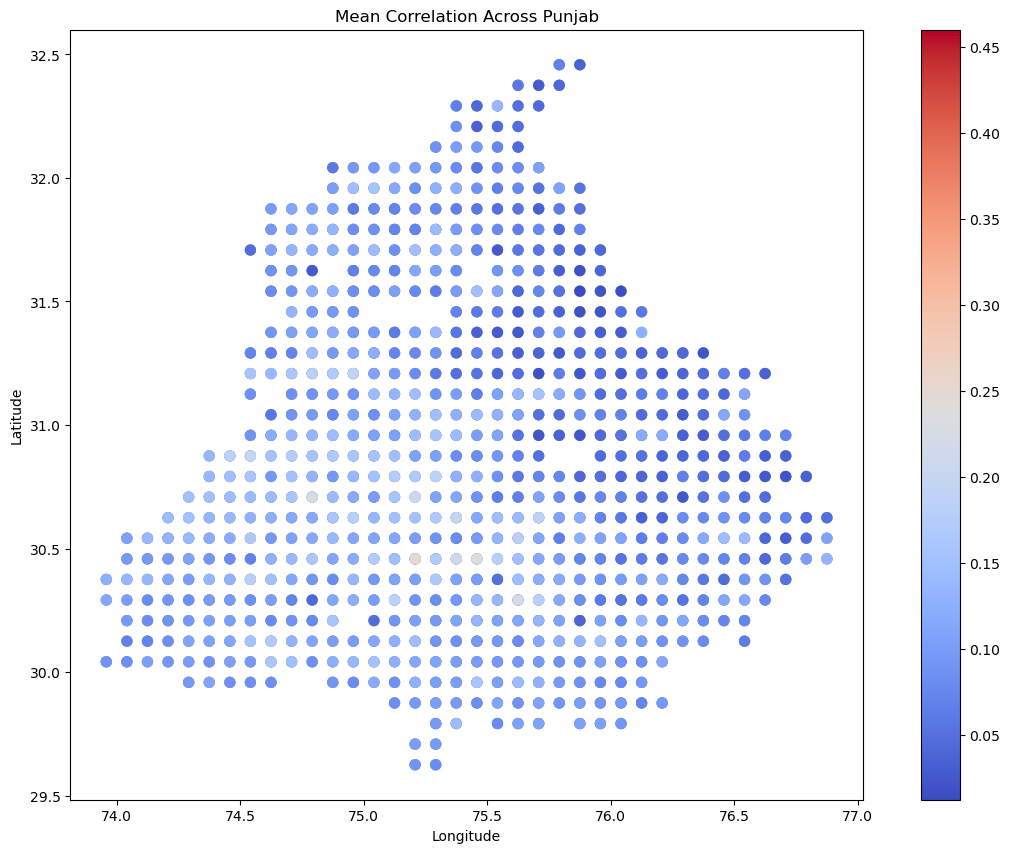

In [6]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load your data from Excel file
data = pd.read_excel(r"C:\Users\riya kansal\Desktop\2015.xlsx")  # Replace with your actual data file path and sheet name

# List of all unique latitude and longitude points
lat_lon_points = data[['LATITUDE', 'LONGITUDE']].drop_duplicates().values.tolist()

# List of fortnight columns for NDVI
ndvi_columns = [f'NDVI{i}' for i in range(1, 9)]

# Create a dictionary to hold correlation matrices and best correlations for each point
correlation_dict = {}
best_correlations = []

# Calculate correlation matrices and find best correlations
for point in lat_lon_points:
    lat, lon = point
    subset = data[(data['LATITUDE'] == lat) & (data['LONGITUDE'] == lon)]
    
    for i in range(1, 9):
        param_cols = [
            f'MaxTemp{i}', f'MinTemp{i}',
            f'DaysMaxTempAbove16{i}', f'DaysMaxTempAbove18{i}', f'DaysMaxTempAbove20{i}', f'DaysMaxTempAbove24{i}',
            f'DaysMinTempBelow16{i}', f'DaysMinTempBelow18{i}', f'DaysMinTempBelow20{i}', f'DaysMinTempBelow24{i}',
            f'Percentile99_Max{i}', f'Percentile95_Max{i}', f'Percentile90_Max{i}',
            f'Percentile99_Min{i}', f'Percentile95_Min{i}', f'Percentile90_Min{i}'
        ]
        combined_cols = ndvi_columns + param_cols
        subset_combined = subset[combined_cols]
        
        # Ensure there are enough data points to calculate the correlation matrix
        if subset_combined.shape[0] > 1:
            corr_matrix = subset_combined.corr()
            correlation_dict[f'Location_{lat}_{lon}_Fortnight_{i}'] = corr_matrix
            
            # Find the highest absolute correlation value and corresponding variable
            corr_unstacked = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
            if len(corr_unstacked) > 1:  # Ensure there are enough entries to avoid index error
                max_corr_value = corr_unstacked.iloc[1]  # Skip the first value (self-correlation)
                best_corr_var = corr_unstacked.index[1]
                
                best_correlations.append({
                    'LATITUDE': lat,
                    'LONGITUDE': lon,
                    'Fortnight': i,
                    'Max_Corr_Value': max_corr_value,
                    'Best_Correlated_Variable': best_corr_var
                })

# Save correlation matrices to an Excel file
output_file = r"C:\Users\riya kansal\Desktop\2014.xlsx"
with pd.ExcelWriter(output_file) as writer:
    for index, (location, corr_matrix) in enumerate(correlation_dict.items()):
        sheet_name = f'Sheet{index+1:03d}'  # Generate unique sheet names like 'Sheet001', 'Sheet002', etc.
        corr_matrix.to_excel(writer, sheet_name=sheet_name)

# Save best correlations to a separate Excel file
best_correlations_df = pd.DataFrame(best_correlations)
best_correlations_output_file = r"C:\Users\riya kansal\Desktop\2013.xlsx"
best_correlations_df.to_excel(best_correlations_output_file, index=False)

# Create a GeoDataFrame with correlation values
corr_values = []
for point, matrix in correlation_dict.items():
    lat, lon = map(float, point.split('_')[1:3])
    max_corr = matrix.values.flatten().max()
    min_corr = matrix.values.flatten().min()
    mean_corr = matrix.values.flatten().mean()
    corr_values.append({'LATITUDE': lat, 'LONGITUDE': lon, 'max_corr': max_corr, 'min_corr': min_corr, 'mean_corr': mean_corr})

corr_df = pd.DataFrame(corr_values)
gdf = gpd.GeoDataFrame(corr_df, geometry=gpd.points_from_xy(corr_df.LONGITUDE, corr_df.LATITUDE))

# Define the output directory for saving the image
output_image_directory = r"C:\Users\riya kansal\Desktop\shap_plots" # Define your output directory
os.makedirs(output_image_directory, exist_ok=True)  # Create the directory if it doesn't exist
output_image_path = os.path.join(output_image_directory, 'mean_correlation_map.png')

# Plot the correlations on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(ax=ax, column='mean_corr', cmap='coolwarm', legend=True, markersize=50)
plt.title('Mean Correlation Across Punjab')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig(output_image_path)

# plt.show() is commented out to avoid displaying the plot in this run-through script
#plt.show()


Not enough data for NDVI1 at (29.625, 75.79166666666666)
Not enough data for NDVI2 at (29.625, 75.79166666666666)
Not enough data for NDVI3 at (29.625, 75.79166666666666)
Not enough data for NDVI4 at (29.625, 75.79166666666666)
Not enough data for NDVI5 at (29.625, 75.79166666666666)
Not enough data for NDVI6 at (29.625, 75.79166666666666)
Not enough data for NDVI7 at (29.625, 75.79166666666666)
Not enough data for NDVI8 at (29.625, 75.79166666666666)
Not enough data for NDVI1 at (29.625, 75.87499999999999)
Not enough data for NDVI2 at (29.625, 75.87499999999999)
Not enough data for NDVI3 at (29.625, 75.87499999999999)
Not enough data for NDVI4 at (29.625, 75.87499999999999)
Not enough data for NDVI5 at (29.625, 75.87499999999999)
Not enough data for NDVI6 at (29.625, 75.87499999999999)
Not enough data for NDVI7 at (29.625, 75.87499999999999)
Not enough data for NDVI8 at (29.625, 75.87499999999999)
Not enough data for NDVI1 at (29.70833333333333, 75.70833333333331)
Not enough data for 

MemoryError: In RendererAgg: Out of memory

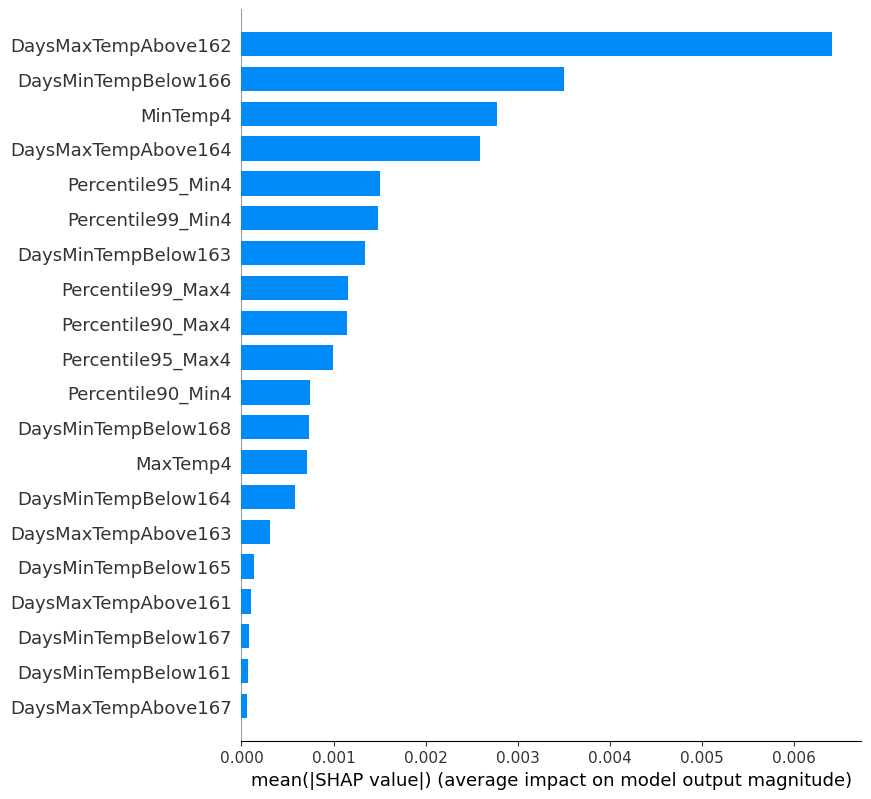

In [4]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import os

excel_file = r"C:\Users\riya kansal\Desktop\2015.xlsx"
data = pd.read_excel(excel_file)

# List of fortnights and NDVI columns
fortnights = list(range(1, 9))
ndvi_cols = [f'NDVI{f}' for f in fortnights]
max_temp_cols = [f'MaxTemp{f}' for f in fortnights]
min_temp_cols = [f'MinTemp{f}' for f in fortnights]

# Get unique latitude and longitude points
lat_long_points = data[['LATITUDE', 'LONGITUDE']].drop_duplicates()

# Create output folder if it doesn't exist
output_folder = 'shap_plots'
os.makedirs(output_folder, exist_ok=True)

# Function to process each lat-long point
def process_lat_long(lat, long, data):
    # Filter data for the specific lat-long point
    point_data = data[(data['LATITUDE'] == lat) & (data['LONGITUDE'] == long)]

    for f in fortnights:
        # Prepare the data for fortnight f
        target = point_data[f'NDVI{f}']
        features = point_data[[f'MaxTemp{f}', f'MinTemp{f}', 
                               f'DaysMaxTempAbove161', f'DaysMaxTempAbove162', f'DaysMaxTempAbove163', f'DaysMaxTempAbove164',
                               f'DaysMaxTempAbove165', f'DaysMaxTempAbove166', f'DaysMaxTempAbove167', f'DaysMaxTempAbove168',
                               f'DaysMinTempBelow161', f'DaysMinTempBelow162', f'DaysMinTempBelow163', f'DaysMinTempBelow164',
                               f'DaysMinTempBelow165', f'DaysMinTempBelow166', f'DaysMinTempBelow167', f'DaysMinTempBelow168',
                               f'Percentile99_Max{f}', f'Percentile95_Max{f}', f'Percentile90_Max{f}',
                               f'Percentile99_Min{f}', f'Percentile95_Min{f}', f'Percentile90_Min{f}']]

        # Drop any rows with NaN values
        features = features.dropna()
        target = target.loc[features.index]

        # Check if we have enough data to train the model
        if features.shape[0] < 10:  # Arbitrary threshold, adjust as needed
            print(f"Not enough data for NDVI{f} at ({lat}, {long})")
            continue

        # Train a model
        model = RandomForestRegressor(n_estimators=100)
        model.fit(features, target)

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(features)

        # Plot SHAP values
        plt.figure()
        shap.summary_plot(shap_values, features, plot_type="bar", show=False)
        plt.title(f'SHAP values for NDVI{f} at ({lat}, {long})')
        plt.savefig(os.path.join(output_folder, f'SHAP_NDVI{f}_{lat}_{long}.png'))
        plt.close()
        print(f"SHAP plot saved for NDVI{f} at ({lat}, {long})")

# Process each lat-long point
for _, row in lat_long_points.iterrows():
    process_lat_long(row['LATITUDE'], row['LONGITUDE'], data)


In [6]:
import pandas as pd
import os
import gc

# Load the combined dataset
file_path = r"C:\Users\riya kansal\Desktop\2015.xlsx"
data = pd.read_excel(file_path)

# List of all column prefixes (excluding NDVI)
columns = [
    'MaxTemp', 'MinTemp', 'DaysMaxTempAbove16', 'DaysMaxTempAbove18', 'DaysMaxTempAbove20', 'DaysMaxTempAbove24',
    'DaysMinTempBelow16', 'DaysMinTempBelow18', 'DaysMinTempBelow20', 'DaysMinTempBelow24',
    'Percentile99_Max', 'Percentile95_Max', 'Percentile90_Max',
    'Percentile99_Min', 'Percentile95_Min', 'Percentile90_Min'
]

# Function to create and save correlation matrices for a specific location
def create_and_save_location_correlation_matrices(data, lat, lon, fortnights=8):
    location_data = data[(data['LATITUDE'] == lat) & (data['LONGITUDE'] == lon)].fillna(0)
    if location_data.empty:
        return
    
    ndvi_cols = [f'NDVI{j}' for j in range(1, fortnights + 1)]
    
    with pd.ExcelWriter(os.path.join(excel_output_folder, f"simultaneous_correlation_{lat}_{lon}.xlsx")) as writer:
        for i in range(1, fortnights + 1):
            other_cols = [f'{col}{i}' for col in columns if f'{col}{i}' in location_data.columns]
            if not other_cols:
                corr_matrix = pd.DataFrame(index=ndvi_cols, columns=other_cols)
            else:
                corr_matrix = location_data[ndvi_cols + other_cols].corr().loc[ndvi_cols, other_cols]
            
            # Save the correlation matrix to an Excel sheet
            sheet_name = f'Fortnight_{i}'[:31]
            corr_matrix.to_excel(writer, sheet_name=sheet_name)
            
            # Force garbage collection
            del corr_matrix, other_cols
            gc.collect()

# Get unique latitude and longitude points
unique_locations = data[['LATITUDE', 'LONGITUDE']].drop_duplicates()

# Define output folder
excel_output_folder = r"C:\Users\riya kansal\Desktop\correlation matrices"

if not os.path.exists(excel_output_folder):
    os.makedirs(excel_output_folder)

# Define batch size
batch_size = 10

# Process locations in batches
for batch_start in range(0, len(unique_locations), batch_size):
    batch = unique_locations.iloc[batch_start:batch_start + batch_size]
    
    for idx, row in batch.iterrows():
        lat, lon = row['LATITUDE'], row['LONGITUDE']
        create_and_save_location_correlation_matrices(data, lat, lon)
    
    # Clear memory after each batch
    gc.collect()

print("Simultaneous correlation matrices have been saved successfully.")


Simultaneous correlation matrices have been saved successfully.


In [12]:
import pandas as pd
import os

# Define the directory containing the original Excel files
input_folder = r"C:\Users\riya kansal\Desktop\correlation matrices"
output_folder = r"C:\Users\riya kansal\Desktop\correlation_matrices"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Define the fortnights and prepare empty data structures to hold data
fortnights = ['Fortnight_1', 'Fortnight_2', 'Fortnight_3', 'Fortnight_4', 'Fortnight_5', 'Fortnight_6', 'Fortnight_7', 'Fortnight_8']
combined_data = {fortnight: {} for fortnight in fortnights}

# Iterate over each file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.xlsx'):
        try:
            file_path = os.path.join(input_folder, file_name)
            print(f"Processing file: {file_path}")

            # Extract latitude and longitude from the file name
            parts = file_name.split('_')
            lat = parts[2]
            lon = parts[3].replace('.xlsx', '')
            lat_long = f"{lat[:6]}_{lon[:6]}"  # Truncate to 6 characters to fit within the limit
            print(f"Extracted lat_long: {lat_long}")

            # Read the Excel file
            xls = pd.ExcelFile(file_path)

            # Extract sheets corresponding to each fortnight
            for fortnight in fortnights:
                if fortnight in xls.sheet_names:
                    sheet_data = pd.read_excel(file_path, sheet_name=fortnight)
                    combined_data[fortnight][lat_long] = sheet_data
        except IndexError:
            print(f"Error: Could not parse latitude and longitude from file name '{file_name}'")
        except Exception as e:
            print(f"Error processing file '{file_name}': {e}")

# Save combined data into new Excel files
for fortnight in fortnights:
    output_file_path = os.path.join(output_folder, f'{fortnight}.xlsx')
    with pd.ExcelWriter(output_file_path) as writer:
        for lat_long, data in combined_data[fortnight].items():
            sheet_name = lat_long[:31]  # Ensure the sheet name is within the limit
            data.to_excel(writer, sheet_name=sheet_name, index=False)

print("Processing complete!")

Processing file: C:\Users\riya kansal\Desktop\correlation matrices\simultaneous_correlation_29.625_75.20833333333331.xlsx
Extracted lat_long: 29.625_75.208
Processing file: C:\Users\riya kansal\Desktop\correlation matrices\simultaneous_correlation_29.625_75.29166666666664.xlsx
Extracted lat_long: 29.625_75.291
Processing file: C:\Users\riya kansal\Desktop\correlation matrices\simultaneous_correlation_29.70833333333333_75.20833333333331.xlsx
Extracted lat_long: 29.708_75.208
Processing file: C:\Users\riya kansal\Desktop\correlation matrices\simultaneous_correlation_29.70833333333333_75.29166666666664.xlsx
Extracted lat_long: 29.708_75.291
Processing file: C:\Users\riya kansal\Desktop\correlation matrices\simultaneous_correlation_29.79166666666667_75.29166666666664.xlsx
Extracted lat_long: 29.791_75.291
Processing file: C:\Users\riya kansal\Desktop\correlation matrices\simultaneous_correlation_29.79166666666667_75.37499999999999.xlsx
Extracted lat_long: 29.791_75.374
Processing file: C:\

In [16]:
import pandas as pd
import os

input_folder = r"C:\Users\riya kansal\Desktop\correlation_matrices"
output_folder = r"C:\Users\riya kansal\Desktop\correlation_images"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over each file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.xlsx'):
        try:
            file_path = os.path.join(input_folder, file_name)
            print(f"Processing file: {file_path}")

            # Read the Excel file
            xls = pd.ExcelFile(file_path)

            # Initialize an empty DataFrame to hold combined data
            combined_df = pd.DataFrame()

            # Iterate over each sheet in the Excel file
            for sheet_name in xls.sheet_names:
                sheet_data = pd.read_excel(file_path, sheet_name=sheet_name)
                sheet_data['Latitude_Longitude'] = sheet_name  # Add a column with the sheet name
                combined_df = pd.concat([combined_df, sheet_data], ignore_index=True)

            # Save the combined DataFrame to a new Excel file
            output_file = os.path.join(output_folder, f'Combined_{file_name}')
            combined_df.to_excel(output_file, index=False)

            print(f"Combined data saved to {output_file}")
        except Exception as e:
            print(f"Error processing file '{file_name}': {e}")

print("Processing complete!")


Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_1.xlsx
Error processing file 'Fortnight_1.xlsx': [Errno 13] Permission denied: 'C:\\Users\\riya kansal\\Desktop\\correlation_images\\Combined_Fortnight_1.xlsx'
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_2.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_2.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_3.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_3.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_4.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_4.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_5.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_5.xlsx
Processing file: C:\Users\riya kansal\D

In [18]:
import pandas as pd
import os

input_folder = r"C:\Users\riya kansal\Desktop\correlation_matrices"
output_folder = r"C:\Users\riya kansal\Desktop\correlation_images"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over each file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.xlsx'):
        try:
            file_path = os.path.join(input_folder, file_name)
            print(f"Processing file: {file_path}")

            # Read the Excel file
            xls = pd.ExcelFile(file_path)

            # Initialize an empty DataFrame to hold combined data
            combined_df = pd.DataFrame()

            # Iterate over each sheet in the Excel file
            for sheet_name in xls.sheet_names:
                sheet_data = pd.read_excel(file_path, sheet_name=sheet_name)

                # Ensure the sheet data is not empty
                if not sheet_data.empty:
                    sheet_data['Sheet_Name'] = sheet_name  # Add a column with the sheet name
                    combined_df = pd.concat([combined_df, sheet_data], ignore_index=True)

            # Check if the combined DataFrame is not empty and has the 'Sheet_Name' column
            if not combined_df.empty and 'Sheet_Name' in combined_df.columns:
                # Save the combined DataFrame to a new Excel file
                output_file = os.path.join(output_folder, f'Combined_{file_name}')
                combined_df.to_excel(output_file, index=False)
                print(f"Combined data saved to {output_file}")
            else:
                print(f"No data to save for file: {file_name}")

        except Exception as e:
            print(f"Error processing file '{file_name}': {e}")

print("Processing complete!")


Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_1.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_1.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_2.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_2.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_3.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_3.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_4.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_4.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_5.xlsx
Combined data saved to C:\Users\riya kansal\Desktop\correlation_images\Combined_Fortnight_5.xlsx
Processing file: C:\Users\riya kansal\Desktop\correlation_matrices\Fortnight_6.xlsx
Combined da